# ヒューマノイドロボット入門Part2
## ヒューマノイドロボットの運動学
### モデルの作成法
以下の12自由度の2足歩行ロボットについて考える。関節の名称とID番号は図のように設定する。
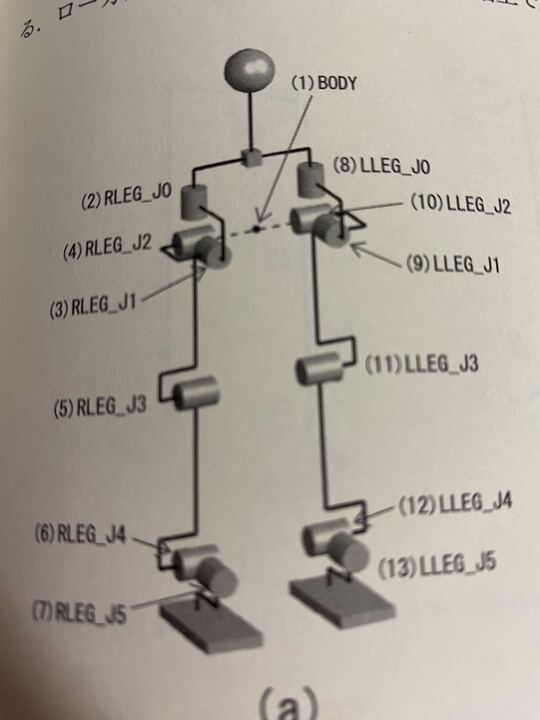

まず各リンクの位置と姿勢を表すためのローカル座標系を設定する必要がある。ローカル座標系の原点は関節の回転軸上であればどこに設定してもよい。
ただし、このロボットの股関節は3軸が1点で交わっているので3つのリンクの原点をすべて股関節の中心に設定するのが合理的である。同様に足首についても2軸の交点を原点に設定する。

また、ローカル座標系の回転行列については基準姿勢において、すべてワールド座標系と平行する。すなわち、\
$$
R_1 = R_2 = ... = R_{13} = E
$$\
設定したローカル座標系は下図のようになる。\
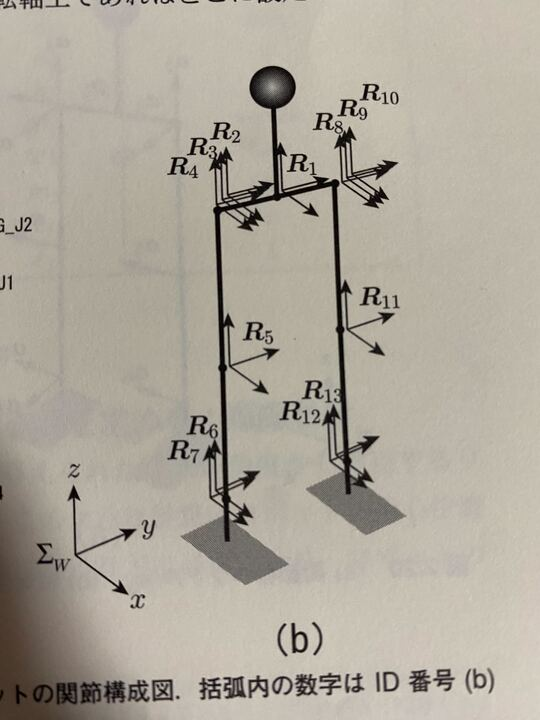

次に隣り合うローカル座標系の間の関係を表現する。
関節軸ベクトル**a**は、親リンクに対する自リンクの回転軸を表すベクトルで、矢印に沿った右ねじの回転方向を正とする。\
例えば、膝関節の関節軸ベクトルは\
$$
    a_5. a_{11} = [0\quad1\quad0]^T
$$
であり、正方向に回転すると膝が通常方向に曲がるように設定されている。\
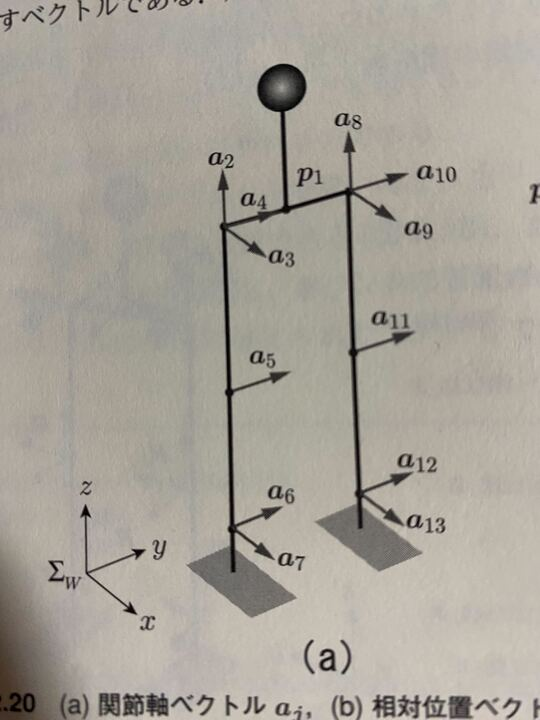

また相対位置ベクトル**b**は、親リンク原点から自リンク原点を指すベクトルである。足首ロール軸のように親リンクと原点を享有する場合には\
$$
b_7, b_{13} = 0
$$
となる。\
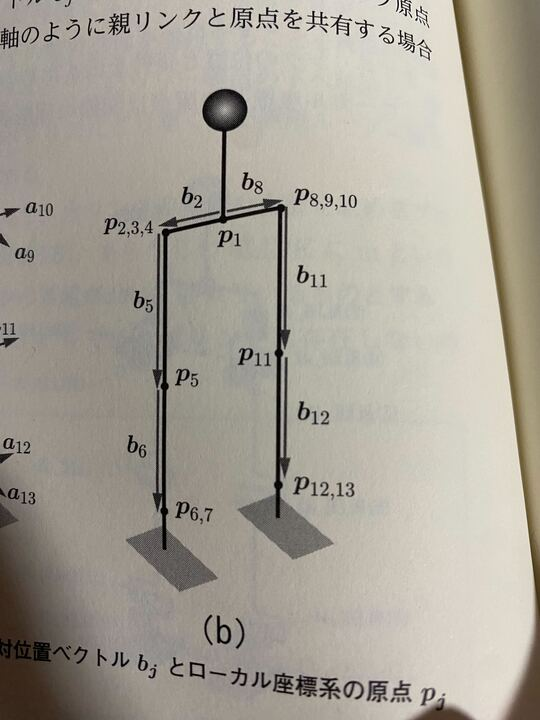

## 関節角度からリンク位置と姿勢を求める：順運動学
**順運動学**とは与えられた関節の角度から注目するリンクの位置と姿勢を求めることをいう。\
このような計算はロボットの重心位置の計算、グラフィック表示、環境との接触判定などに必要になり、ロボットのシミュレーションの根幹をなす。\
順運動学の計算は同次変換行列(1)とチェーンルール(2)によって簡単に行える。\
まず以下のような1個のリンクの同次変換行列を求める。関節回転軸上に原点を持つローカル座標系$Σ_j$を設定する。親リンク座標系で見た回転軸ベクトルが$a_j$、$Σ_j$の原点が$b_j$である。関節の回転角を$q_j$、回転角0の初期状態におけるリンクの姿勢行列を**E**とする。\
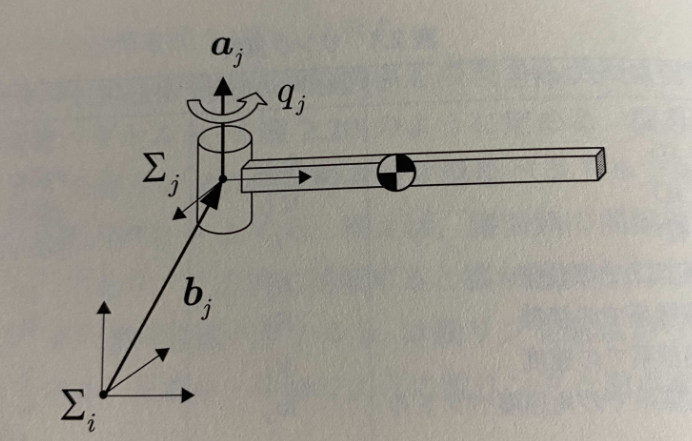

$Σ_j$の親リンク相対の同次変換行列は\
$$
^iT_j = 
\begin{bmatrix}
e^{\hat{a_j}q_j} & b_j\\
000 & 1\\
\end{bmatrix}
$$

ここで、ウェッジ(^)は3次元ベクトルからひずみ対称行列を作る操作である。詳しくはこのファイルの最後で説明する。(3)

次に下図のように連続した二つのリンクi, jがあり、親リンクの絶対位置・姿勢$p_j$, $R_j$が既知であるとする。すなわち$Σ_j$の同次変換行列は
$$
T_j = 
\begin{bmatrix}
R_j & p_i \\
000 & 1 \\
\end{bmatrix}
$$

$Σ_j$の同次変換行列はチェーンルールにより
$$
T_j = T_j^iT_j
$$


これらより、$Σ_j$の絶対位置・姿勢($p_j$, $R_j$)は次式で与えられる。
$$
p_j = p_i + R_ib_j
$$
$$
R_j = R_i^{\hat{a_j}q_j}
$$

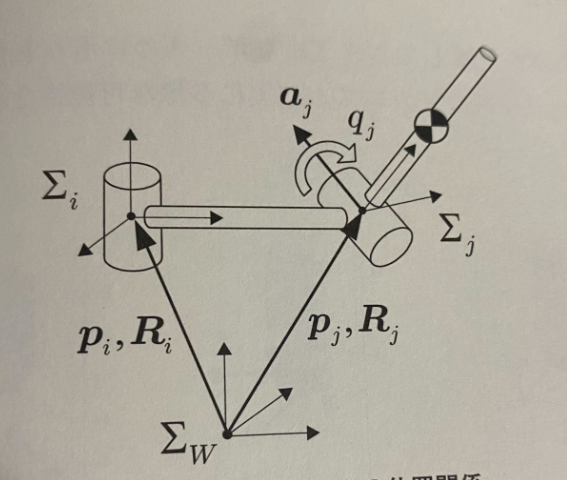

この関係式とPart1で説明した方法を用いれば、全リンクの位置と姿勢を計算するプログラムは次のPythonコードのように簡潔なものになる。\
予めボディリンクの絶対位置uLINK(1).p、絶対姿勢uLINK(1).Rおよび各リンクの関節回転角度qを設定しておき、ForwardKinematics(1)を実行することで自動的に全リンクの位置と姿勢が更新される。

In [3]:
# 順運動学の関数
def forward_kinematics(j):
    global uLINK

    if j == 0:
        return
    if j != 1:
        mom = uLINK[j].mother
        uLINK[j].p = uLINK[mom].R @ uLINK[j].b + uLINK[mom].p
        uLINK[j].R = uLINK[mom].R @ rodrigues(uLINK[j].a, uLINK[j].q)
    forward_kinematics(uLINK[j].sister)
    forward_kinematics(uLINK[j].child)

## リンクの位置と姿勢から関節角度を求める：逆運動学
次に与えられた胴体と足部の位置・座標から各関節の角度を求める方法について考える。このような場合に必要になるのが**逆運動学**である。\
例えば視覚センサで階段の高さの情報がわかっていたとして、正しい位置と高さに足を着地させるためには逆運動学が必須である。\
逆運動学は解析的に解く方法と数値的に解く方法の2種類がある。はじめに解析的に解く方法について説明する。

### 逆運動学の解析的な解法
先ほどのモデルの右足についてだけ考え、胴体と右足の位置姿勢がそれぞれ($p_1$, $R_1$), ($p_7$, $R_7$)として与えられたとする。式を見やすくするため下図のように胴体原点から見た股関節の位置を$D$, 大腿の長さを$A$, 下腿の長さを$B$とする。\
したがって股関節の位置は
$$
p_2 = p_1 + R_1
\begin{bmatrix}
0\\
D\\
0\\
\end{bmatrix}
$$
となる。\
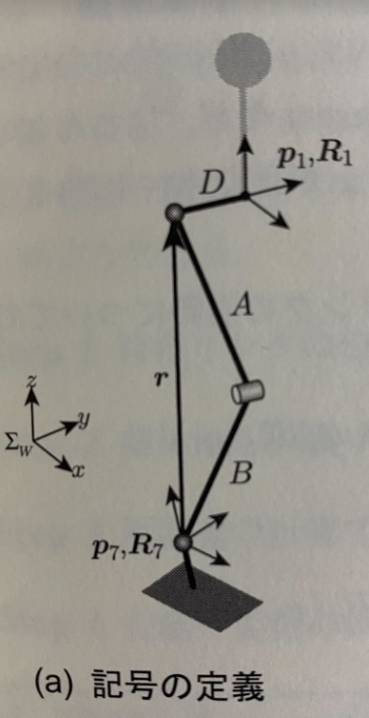

次に、足首の座標系から見た股関節の位置ベクトルを計算する。
$$
r = R^T_7(p_2-p_7) = 
\begin{bmatrix}
r_x r_y r_z
\end{bmatrix}
^T
$$
ここから足首と股関節の距離が求まる。これを$C$と定義する。
$$
C = \sqrt{r^2_x + r^2_y + r^2_z}
$$
下図に示すように三角形$ABC$を考えれば膝の回転角度$q_5$が求められる。\
**余弦定理**より、
$$
C^2 = A^2 + B^2 - 2AB\cos(\pi - q_5)
$$
よって、膝の回転角度は
$$
q_5 = -\cos^{-1}(\frac{A^2 + B^2 + C^2}{2AB}) + \pi
$$
となる。三角形の下端の角度を$α$とすると、**正弦定理**より
$$
\frac{C}{\sin(\pi - q_5)} = \frac{A}{\sinα}
$$
よって、
$$
α = \sin^{-1}(\frac{A\sin(\pi - q_5)}{C})
$$
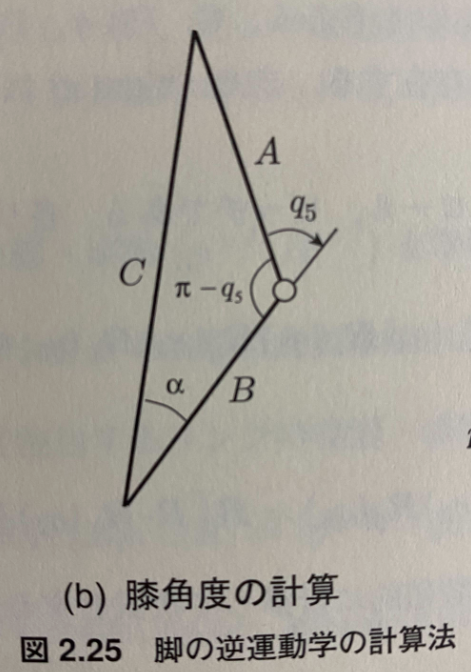

次に足首座標系を基準にして考えれば、下図のようにベクトル**r**から足首ロール、ピッチ軸関節角をもとめることができる。すなわち
$$
q_7 = \arctan(r_y, r_z)
q_6 = \arctan(r_x, sign(r_z)\sqrt{r^2_y + r^2_z}) - α
$$
ここで、sign(x)はxが正なら+1、負ならば-1となる関数である。\
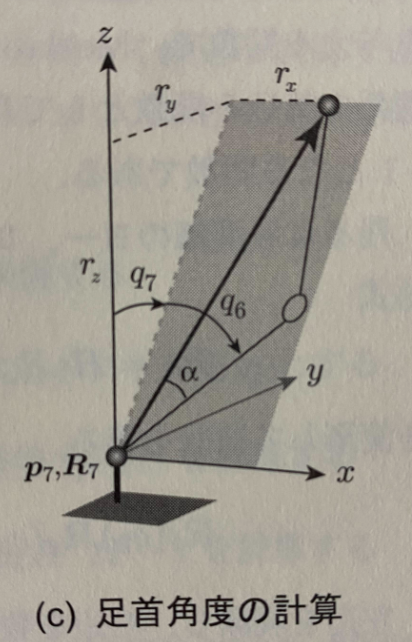

残るのは股関節のヨー、ロール、ピッチである。各リンクの姿勢についての関係式
$$
R_7 = R_1R_z(q_2)R_x(q_3)R_y(q_4)R_y(q_5 + q_6)R_x(q_7)
$$
を変形して次式を得る。
$$
R_z(q_2)R_x(q_3)R_y(q_4) = R^T_1R_7R_x(q_7)R_y(q_5 + q_6)
$$
左辺を展開し、右辺を数値的に計算して次式とする。
$$
\begin{bmatrix}
c_2c_4 - s_2s_3s_4 & -s_2c_3 & c_2s_4 + s_2s_3c_4 \\
s_2c_4 + c_2s_3s_4 & c_2c_3 & s_2s_4 - c_2s_3c_4 \\
-c_3s_4 & s_3 c_3c_4 \\
\end{bmatrix}
=
\begin{bmatrix}
R_{11} & R_{12} & R_{13} \\
R_{21} & R_{22} & R_{23} \\
R_{31} & R_{32} & R_{33} \\
\end{bmatrix}
$$

ここで、$c_2 = \cos q_2$,  $s_2 = \sin q_2$と表記した。左辺の行列の要素を注意深く検討して以下のように答えを得る。
$$
q_2 = \arctan(-R_{12}, R_{22})
$$
$$
q_3 = \arctan(R_{32}, -R_{12}s_2 + R_{22}c_2)\
$$
$$
q_4 = \arctan(-R_{31}, R_{33})
$$

ここまでをプログラムとしてまとめた例が以下である。

In [4]:
import numpy as np

def IK_leg(Body, D, A, B, Foot):
    r = np.dot(Foot.R.T, (Body.p + np.dot(Body.R, np.array([0, D, 0]).T) - Foot.p))  # Foot-to-Body vector
    C = np.linalg.norm(r)
    c5 = (C**2 - A**2 - B**2) / (2.0 * A * B)
    if c5 >= 1:
        q5 = 0.0
    elif c5 <= -1:
        q5 = np.pi
    else:
        q5 = np.arccos(c5)  # knee pitch
    q6a = np.arcsin((A / C) * np.sin(np.pi - q5))   # ankle pitch sub
    q7 = np.arctan2(r[1], r[2])  # ankle roll -pi/2 < q(6) < pi/2
    if q7 > np.pi / 2:
        q7 = q7 - np.pi
    elif q7 < -np.pi / 2:
        q7 = q7 + np.pi
    q6 = -np.arctan2(r[0], np.sign(r[2]) * np.sqrt(r[1]**2 + r[2]**2)) - q6a  # ankle pitch

    R = np.dot(np.dot(np.dot(Body.R.T, Foot.R), Rroll(-q7)), Rpitch(-q6 - q5))  # hipZ*hipX*hipY
    q2 = np.arctan2(-R[0, 1], R[1, 1])  # hip yaw
    cz = np.cos(q2)
    sz = np.sin(q2)
    q3 = np.arctan2(R[2, 1], -R[0, 1] * sz + R[1, 1] * cz)  # hip roll
    q4 = np.arctan2(-R[2, 0], R[2, 2])  # hip pitch

    q = np.array([q2, q3, q4, q5, q6, q7])
    return q


### 逆運動学の数値解法
逆運動学の解析解を求めるのと比べると、順運動学の数値解ははるかに簡単に計算することができる。そこで、順運動学を使って繰り返し計算で逆運動学を解く下図のような方法が考えられる。アルゴリズムで示せば以下のようになる。
- Step1 目標リンクの位置・姿勢（$p^{ref}$, $R^{ref}$）を準備する
- Step2 胴体から目標リンクなでの関節角度を並べたベクトルを**q**をする
- Step3 順運動学計算で注目するリンクの位置・姿勢(**p**, **R**)を計算する
- Step4 位置・姿勢の誤差($\Delta{p}$, $\Delta{R}$) = ($p^{ref} - p$, $R^{T}$, $R^{ref}$)を計算する

- Step5 ($\Delta p$, $\Delta R$)が十分小さければ終了
- Step6 ($\Delta p$, $\Delta R$)が大きければ、これを小さくするような関節角度修正量$\Delta q$を計算する
- Step7 $q := q + \Delta q$としてStep3に戻る
 
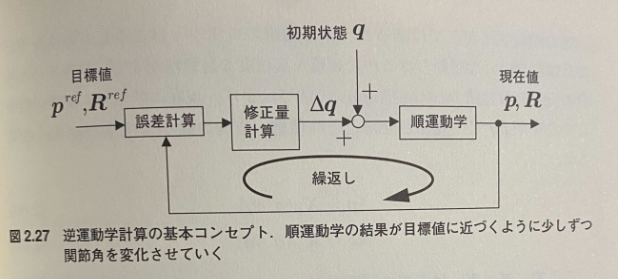

これを実際にプログラムにするには以下の二つの課題がある。
- 位置・姿勢の誤差($\Delta{p}$, $\Delta{R}$)が十分小さいとはどういうことか？(Step5)
- 位置・姿勢の誤差を小さくするような関節角度修正量$\Delta{q}$をどうやって計算するのか？(Step6)

前者は比較的簡単に解決できる。位置・姿勢の誤差が0である状態は次式で表せる。
$$
\Delta{p} = 0
\Delta{R} = E
$$

この状態を0とし、そこから離れるほど大きくなるような関数の一例は
$$
err(\Delta{p}, \Delta{R}) = ||\Delta{p}||^2 + ||\Delta\omega||^2
$$
$$
\Delta\omega = (ln\Delta{R})^{\breve{}}
$$

二番目の問題はともかく$err(\Delta{p}, \Delta{R})$を小さく関節角度修正量$\Delta{q}$を見つければよい。そこで、Newton-Raphson法ではまず現在の状態から関せる角度をごくわずかな$\delta{q}$だけ変化させたときの位置・姿勢の微小変化量($\delta p$, $\delta \omega$)を考える。
$$
\delta p = X_p(q, \delta q)
$$
$$
\delta \omega = X_{\omega}(q, \delta q)
$$
ここで、$X_p$, $X_{\omega}$は未知の関数だが、$\delta q$が小さな場合には単なる掛け算と足し算で表してOKだと考える。これは行列で書くと以下のようになる。
$$
\begin{bmatrix}
\delta p \\
\delta \omega\\
\end{bmatrix}
=
\begin{bmatrix}
J_{11} & J_{12} & ... & J_{15} & J_{16} \\
: & : & ... & : & : \\
J_{61} & J_{62} & ... & J_{65} & J_{66} \\
\end{bmatrix}
\delta q
$$

ここで、$J_{ij}$はロボットの現在の位置、姿勢によって決まる定数だとする。（関節の数は6とした）毎回すべての要素を書くのは面倒なのでこれを以下のように単純化して書く。
$$
\begin{bmatrix}
\delta p \\
\delta \omega\\
\end{bmatrix}
= J \delta q
$$
ここで現れる行列**J**は**ヤコビアン**と呼ばれている。
一旦式を認めると、単に逆行列で修正量が求められる。
$$
\delta q = \lambda J^{-1}
\begin{bmatrix}
\delta q \\
\delta \omega
\end{bmatrix}
$$
これがStep6において、位置・姿勢の誤差から関節角度の修正量を計算する式となる。なお$\lambda \in (0\quad1]$は数値計算を安定化するために用いる係数である。
以下は逆運動学のPythonプログラムである。

In [5]:
import numpy as np

def InverseKinematics(to, Target):
    global uLINK

    lambda_val = 0.5
    idx = FindRoute(to)
    ForwardKinematics(1)
    err = CalcVWerr(Target, uLINK[to])
    
    for _ in range(10):
        J = CalcJacobian(idx)
        err = CalcVWerr(Target, uLINK[to])
        
        if np.linalg.norm(err) < 1E-6:
            return np.linalg.norm(err)
        
        for nn, j in enumerate(idx):
            uLINK[j].q = uLINK[j].q + dq[nn]
        
        ForwardKinematics(1)

    return np.linalg.norm(err)

関数InverseKinematicsの使用例は以下のようになる。まず胴体の位置と姿勢を設定し、次に右足、左足の順に希望する位置と姿勢をもっていく。これで2足歩行を実現するための最初の重要なツールができた。

In [40]:
exec(open('import.py').read())

In [41]:
# Create link instances
uLINK = [
    Link('BODY', 0, 2, 10),
    Link('RARM', 4, 3, 5),
    Link('RHAND', 0, 0, 1),
    Link('LARM', 6, 5, 5),
    Link('LHAND', 0, 0, 1),
    Link('RLEG', 8, 7, 6),
    Link('RFOOT', 0, 0, 2),
    Link('LLEG', 0, 9, 6),
    Link('LFOOT', 0, 0, 2)
]

# Print link information
print_links_info(uLINK)

[[[[[ uLINK struct was set as following ]]]]]
-------------------------------------
ID     name    sister child   mass
-------------------------------------
1  BODY          0     2      10.00
2  RARM          4     3       5.00
3  RHAND         0     0       1.00
4  LARM          6     5       5.00
5  LHAND         0     0       1.00
6  RLEG          8     7       6.00
7  RFOOT         0     0       2.00
8  LLEG          0     9       6.00
9  LFOOT         0     0       2.00



In [42]:
# TODO 可視化
ToRad = math.pi / 180
uLINK[0].p = np.array([0.0, 0.0, 0.55])
uLINK[0].R = rpy2rot(0.0, 0.0, -10 * ToRad)

Rfoot = uLINK[6]
Rfoot.p = np.array([0.3, -0.1, 0])
Rfoot.R = rpy2rot(0, 20 * ToRad, 0)

Lfoot = uLINK[8]
Lfoot.p = np.array([0.3, -0.1, 0])
Lfoot.R = rpy2rot(0, 20 * ToRad, 0)

InverseKinematics(LLEG_J5, Lfoot)

DrawAllJoints(1)  # Display the robot

TypeError: Link.__init__() missing 4 required positional arguments: 'name', 'sister', 'child', and 'm'

## 参考
(1)同次変換行列\
-Qiita記事\
https://qiita.com/akinami/items/9e65389929cedb1c9551

-研究室CPS_Lecture\
https://github.com/IRSL-tut/CPS-lecture/blob/main/notebooks/cps_lecture_coords00.ipynb

(2)チェーンルール\
同次変換行列どうしの掛け算の際に以下のようになる性質のこと
$$
^0T_1^1T_2...^{N-1}T_{N} = ^0T_N
$$
(3)ウェッジ\
以下記事でひずみ変換行列について書かれているのでそこを読むとよい。\
https://note.com/ss_sports_lab/n/na80cd8198d22